<a href="https://colab.research.google.com/github/lsh3163/Imagenet-Better/blob/master/Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Do Better ImageNet Models Transfer Better?


## Library

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

## Parameter

In [2]:
NUM_GPUS = 1
BS_PER_GPU = 256 # Batchsize = 4x64
NUM_EPOCHS = 200
TASK=2 # Task 1 : Logistic Regression, Task2 : Transfer learning, Task3 : Random Initialization(Scratch Training)
MODEL = "mobilenet_v1" # mobilenet_v1, mobilenet_v2
NUM_CLASSES = 10
DATASET = "oxford_flowers102" # food101, cifar10, cifar100, sun397, oxford_flowers102, caltech101
learning_rate = 0.01

In [3]:
metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="top_K")]
if DATASET=="cifar10":
  NUM_CLASSES=10
elif DATASET=="cifar100":
  NUM_CLASSES=100
elif DATASET=="food101":
  NUM_CLASSES=101
elif DATASET=="sun397":
  NUM_CLASSES=397
elif DATASET=="oxford_flowers102" or DATASET=="caltech101":
  NUM_CLASSES=102
  metrics=["acc"]

## Dataset

In [4]:
def normalize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 127.5 - 1., label

In [5]:
(train_dataset, test_dataset), ds_info = tfds.load(
    DATASET,
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train = train_dataset.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BS_PER_GPU * NUM_GPUS)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = test_dataset.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BS_PER_GPU * NUM_GPUS)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Model

In [6]:
if TASK==1:
    include_top=False
    weights="imagenet"
    trainable=False
elif TASK==2:
    include_top=False
    weights="imagenet"
    trainable=True
elif TASK==3:
    include_top=False
    weights=None
    trainable=True


if MODEL=="mobilenet_v1":
    base_model = tf.keras.applications.MobileNet(input_shape=None,
                                            include_top=include_top,
                                            weights=weights)
elif MODEL=="mobilenet_v2":
    base_model = tf.keras.applications.MobileNetV2(input_shape=None,
                                                 include_top=include_top,
                                                 weights=weights)

# Freeze the pre-trained model weights
base_model.trainable = trainable

# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

# Layer classification head with feature detector
model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, decay=1e-6, nesterov=True),
              loss='sparse_categorical_crossentropy',
              metrics=metrics
              # metrics=["acc"]
)
print(model.summary())

<ipython-input-6-52ca54127ce4>:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(input_shape=None,
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, None, None,     │     3,228,864 │
│                                 │ 1024)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1024)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 102)            │       104,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,333,414 (12.72 MB)

 Trainable params: 3,311,526 (12.63 MB)

 Non-trainable params: 21,888 (85.50 KB)

None


In [7]:

history = model.fit(ds_train,
          validation_data=ds_test,
          validation_freq=1,
          epochs=NUM_EPOCHS, shuffle=True)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 112s 20s/step - acc: 0.0188 - loss: 14.3696 - val_acc: 0.0416 - val_loss: 14.4350
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - acc: 0.3468 - loss: 12.1095 - val_acc: 0.0387 - val_loss: 11.0314
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - acc: 0.6414 - loss: 10.5288 - val_acc: 0.0530 - val_loss: 8.9299
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - acc: 0.8110 - loss: 5.4889 - val_acc: 0.0551 - val_loss: 7.3343
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - acc: 0.8743 - loss: 1.4438 - val_acc: 0.0455 - val_loss: 6.2573
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - acc: 0.9383 - loss: 0.3663 - val_acc: 0.0486 - val_loss: 5.7572
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - acc: 0.9652 - loss: 0.1967 - val_acc: 0.0543 - val_loss: 5.5181
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - acc: 0.9708 - loss: 0.1624 - val_acc: 0.0616 - val_loss: 5.3588
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - acc: 0.9846 - loss: 0.1159 -

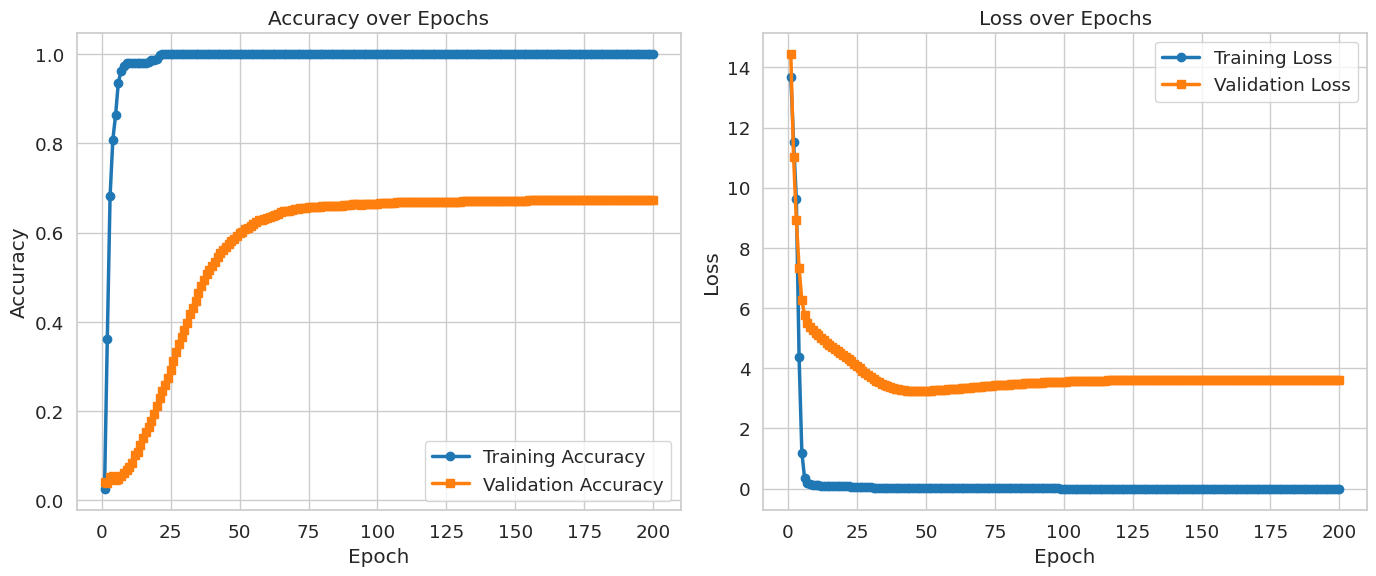

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

#  seaborn
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# get data from history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', color='tab:blue', linewidth=2.5, marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='tab:orange', linewidth=2.5, marker='s')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', color='tab:blue', linewidth=2.5, marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='tab:orange', linewidth=2.5, marker='s')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
